# Test Fluency Evaluation on GUG dataset

In [ ]:
%pip install language-tool-python
%pip install thefuzz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jellyfish
from scipy import stats
from minineedle import needle, smith, core
from nltk import ngrams
import language_tool_python
from thefuzz import fuzz

from transformers import pipeline

## fix sentences using the models

In [2]:
data = pd.read_csv("/home/mlynatom/data/gug/gug_annotations.tsv", sep="\t")

In [3]:
display(data.info())
display(data.describe())
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Id                       3129 non-null   int64  
 1   Sentence                 3129 non-null   object 
 2   Expert Judgement         3129 non-null   int64  
 3   Crowd Flower Judgements  3129 non-null   object 
 4   Average                  3129 non-null   float64
 5   Dataset                  3129 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 146.8+ KB


None

,Id,Expert Judgement,Average
count,3129.000000,3129.000000,3129.000000
mean,1565.000000,2.989134,2.925109
std,903.408822,0.945042,0.753132
min,1.000000,0.000000,0.000000
25%,783.000000,3.000000,2.666667
50%,1565.000000,3.000000,3.000000
75%,2347.000000,4.000000,3.333333
max,3129.000000,4.000000,4.000000


,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset
0,1,If the teacher once entered in to the class sh...,3,"[3, 3, 3, 4, 2]",3.000000,train
1,2,So I think we can not live if old people could...,2,"[2, 2, 1, 2, 3]",2.000000,test
2,3,New and new technology has been introduced to ...,3,"[3, 4, 3, 3, 2]",3.000000,dev
3,4,For not use car.,1,"[3, 4, 3, 4, 3]",3.000000,test
4,5,Here was no promise of morning except that we ...,3,"[2, 4, 3, 2, 3]",2.833333,test


In [4]:
input_sentences = data.Sentence
input_sentences

0       If the teacher once entered in to the class sh...
1       So I think we can not live if old people could...
2       New and new technology has been introduced to ...
3                                        For not use car.
4       Here was no promise of morning except that we ...
                              ...                        
3124              Sceene of violence can affect on them .
3125    In other words, the image in the TV comercial ...
3126    Members gather money for the funeral and help ...
3127    Show the employer that you are willing to do a...
3128    While the communities in general have reckoned...
Name: Sentence, Length: 3129, dtype: object

In [5]:
task_prefix = "Fix the grammar: "
inputs = [task_prefix + sentence for sentence in input_sentences]

In [9]:
coedit = pipeline("text2text-generation", model="grammarly/coedit-large", tokenizer="grammarly/coedit-large", framework="pt", device=0, batch_size = 128)

In [10]:
output = coedit(inputs, max_length=400)
data["FixedSentence_CoeditLarge"] = [x["generated_text"] for x in output]

In [7]:
data.head()

,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditLarge
0,1,If the teacher once entered in to the class sh...,3,"[3, 3, 3, 4, 2]",3.000000,train,"If the teacher once entered the class, she sho..."
1,2,So I think we can not live if old people could...,2,"[2, 2, 1, 2, 3]",2.000000,test,So I think we cannot live if old people could ...
2,3,New and new technology has been introduced to ...,3,"[3, 4, 3, 3, 2]",3.000000,dev,New and new technology has been introduced to ...
3,4,For not use car.,1,"[3, 4, 3, 4, 3]",3.000000,test,For not to use a car.
4,5,Here was no promise of morning except that we ...,3,"[2, 4, 3, 2, 3]",2.833333,test,Here was no promise of morning except that as ...


In [6]:
coedit_xl = pipeline("text2text-generation", model="grammarly/coedit-xl", tokenizer="grammarly/coedit-xl", framework="pt", device=0, batch_size = 64)

In [7]:
output = coedit_xl(inputs, max_length=400)
data["FixedSentence_CoeditXL"] = [x["generated_text"] for x in output]

In [11]:
data.head()

,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge
0,1,If the teacher once entered in to the class sh...,3,"[3, 3, 3, 4, 2]",3.000000,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho..."
1,2,So I think we can not live if old people could...,2,"[2, 2, 1, 2, 3]",2.000000,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...
2,3,New and new technology has been introduced to ...,3,"[3, 4, 3, 3, 2]",3.000000,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...
3,4,For not use car.,1,"[3, 4, 3, 4, 3]",3.000000,test,For not use a car.,For not to use a car.
4,5,Here was no promise of morning except that we ...,3,"[2, 4, 3, 2, 3]",2.833333,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...


In [13]:
data.to_csv("/home/mlynatom/data/gug/gug_fixed.tsv", sep="\t")

## View of Results

In [2]:
#data = pd.read_csv("/home/mlynatom/data/gug/gug_fixed.tsv", sep="\t")
data = pd.read_csv("/home/mlynatom/data/gug/gug_fixed_perplexity.tsv", sep="\t")

In [3]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL
0,0,0,1,If the teacher once entered in to the class sh...,3,"[3, 3, 3, 4, 2]",3.000000,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564
1,1,1,2,So I think we can not live if old people could...,2,"[2, 2, 1, 2, 3]",2.000000,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534
2,2,2,3,New and new technology has been introduced to ...,3,"[3, 4, 3, 3, 2]",3.000000,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526
3,3,3,4,For not use car.,1,"[3, 4, 3, 4, 3]",3.000000,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060
4,4,4,5,Here was no promise of morning except that we ...,3,"[2, 4, 3, 2, 3]",2.833333,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502


In [4]:
data[data["Expert Judgement"] == 0]

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL
55,55,55,56,But experts believe that it was a result of er...,0,[],0.0,none,But experts believe that it was a result of er...,But experts believe that it was a result of er...,114.859818,93.502632,114.859871
64,64,64,65,maybe not giving the exsact same response (bec...,0,[],0.0,none,Maybe not giving the exact same response (beca...,Maybe not giving the exact same response (beca...,390.735718,164.464371,151.346191
67,67,67,68,in organisations when the CEO or the MD makes ...,0,[],0.0,none,"In organizations, when the CEO or the MD makes...","In organisations, when the CEO or the MD makes...",68.074364,35.032078,38.072365
89,89,89,90,"Suth as, culers and people",0,[],0.0,none,"Such as, culers and people.","Among them are Satan, culers, and people.",3511.087158,350.795105,684.449585
91,91,91,92,"Second, it is truffce that",0,[],0.0,none,"Second, it is truffy that","Second, it is truffce that",1236.006958,1236.010498,392.437164
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2956,2956,2956,2957,And electrics products?,0,[],0.0,none,And electronics products?,And electric products?,3069.436279,2754.073975,2095.777344
3026,3026,3026,3027,first iwill make some mony by working in a com...,0,[],0.0,none,"First, I will make some money by working in a ...","First, I will make some money by working in a ...",256.181335,25.804905,25.804880
3041,3041,3041,3042,So that whay,0,[],0.0,none,So that's why,So that is what,1506.856567,55.015690,36.061562
3071,3071,3071,3072,They can learn with companies' disasters and h...,0,[],0.0,none,They can learn from companies' disasters and h...,They can learn from companies' disasters and h...,188.131958,94.344391,117.339272


remove rows with 0

In [5]:
data = data[data["Expert Judgement"] != 0]

normalize Average and Expert

In [6]:
def standardize(column):
    return (column - column.mean()) /column.std()

In [7]:
def normalize(column):
    return  (column - column.min())/(column.max() - column.min())

In [8]:
data["Average"] = normalize(data["Average"])
data["Expert Judgement"] = normalize(data["Expert Judgement"])

In [9]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502


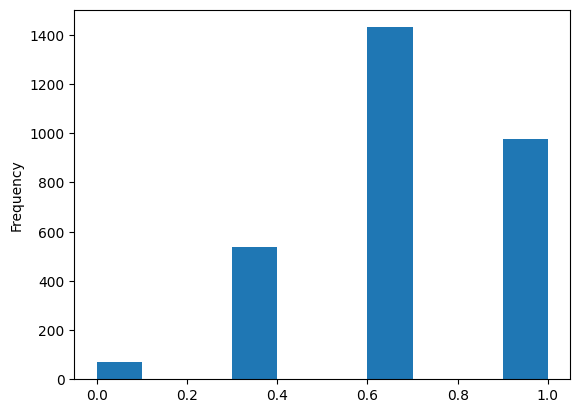

In [10]:
data["Expert Judgement"].plot(kind="hist")
plt.show()

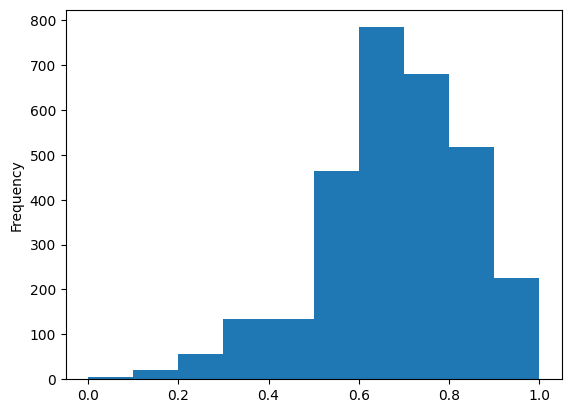

In [11]:
data["Average"].plot(kind="hist")
plt.show()

In [12]:
def compute_correlations(df, metric_name):
    p_corr1 = stats.pearsonr(df["Average"], df[f"{metric_name}_L"])
    p_corr2 = stats.pearsonr(df["Expert Judgement"], df[f"{metric_name}_L"])
    p_corr3 = stats.pearsonr(df["Average"], df[f"{metric_name}_XL"])
    p_corr4 = stats.pearsonr(df["Expert Judgement"], df[f"{metric_name}_XL"])

    k_corr1 = stats.kendalltau(df["Average"], df[f"{metric_name}_L"])
    k_corr2 = stats.kendalltau(df["Expert Judgement"], df[f"{metric_name}_L"])
    k_corr3 = stats.kendalltau(df["Average"], df[f"{metric_name}_XL"])
    k_corr4 = stats.kendalltau(df["Expert Judgement"], df[f"{metric_name}_XL"])

    print(f"pearsonr average, {metric_name}_L {p_corr1}")
    print(f"pearsonr expert, {metric_name}_L {p_corr2}")
    print(f"pearsonr average, {metric_name}_XL {p_corr3}")
    print(f"pearsonr expert, {metric_name}_XL {p_corr4}")

    print(f"kendalltau average, {metric_name}_L {k_corr1}")
    print(f"kendalltau expert, {metric_name}_L {k_corr2}")
    print(f"kendalltau average, {metric_name}_XL {k_corr3}")
    print(f"kendalltau expert, {metric_name}_XL {k_corr4}")

## Evaluate Proposed Metrics

### Jaccard Similarity

In [14]:
def jaccard_similarity(str1:str, str2: str) -> float:
    """
    Computes Jaccard similarity (index) of 2 strings. 
    https://en.wikipedia.org/wiki/Jaccard_index
    """
    set1 = set(str1.split())
    set2 = set(str2.split())

    intersection = set1.intersection(set2)
    union = set1.union(set2)
    j_sim = len(intersection)/len(union)
    return j_sim

data["Jaccard_sim_L"] = [jaccard_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data["Jaccard_sim_XL"] = [jaccard_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]

In [15]:
data

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,Jaccard_sim_L,Jaccard_sim_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,0.666667,0.666667
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,0.636364,0.636364
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,0.900000,0.900000
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,0.666667,0.800000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,0.863636,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3124,3124,3125,Sceene of violence can affect on them .,0.666667,"[2, 2, 3, 3, 3]",0.555556,test,Scenes of violence can affect them.,The scene of violence can affect them .,1779.499634,409.441437,184.862381,0.600000,0.400000
3125,3125,3125,3126,"In other words, the image in the TV comercial ...",0.333333,"[3, 1, 2, 3, 3]",0.444444,dev,"In other words, the image in the TV commercial...","In other words, the image in the TV commercial...",82.769379,25.436802,25.695061,0.720000,0.791667
3126,3126,3126,3127,Members gather money for the funeral and help ...,1.000000,"[3, 4, 4, 4, 3]",0.888889,dev,Members gather money for the funeral and help ...,Members gather money for the funeral and help ...,265.311066,265.311066,265.308929,1.000000,1.000000
3127,3127,3127,3128,Show the employer that you are willing to do a...,1.000000,"[2, 3, 4, 3, 4]",0.777778,train,Show your employer that you are willing to do ...,Show the employer that you are willing to do a...,39.979969,36.265869,30.948215,0.882353,0.833333


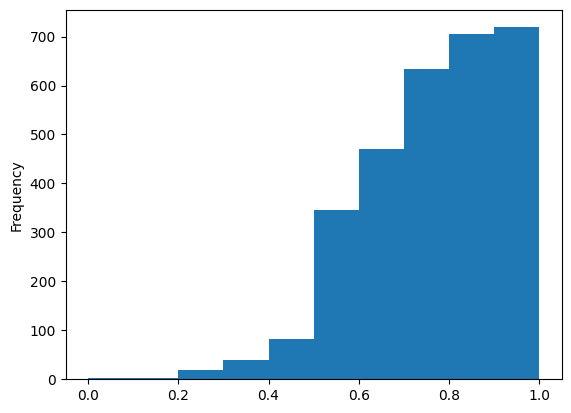

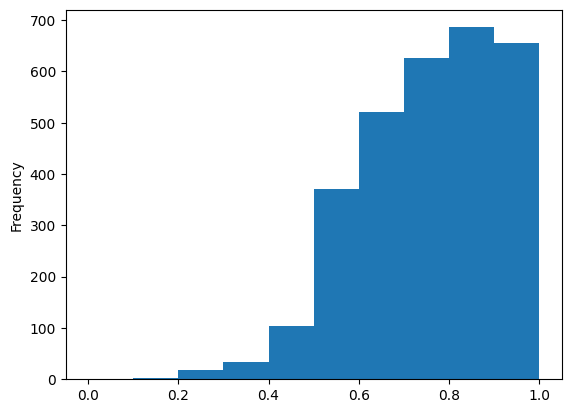

In [16]:
data["Jaccard_sim_L"].plot(kind="hist")
plt.show()
data["Jaccard_sim_XL"].plot(kind="hist")
plt.show()

In [17]:
compute_correlations(data, "Jaccard_sim")

pearsonr average, Jaccard_sim_L (0.5021093343636623, 1.3860797055398435e-192)
pearsonr expert, Jaccard_sim_L (0.4161227498423274, 9.418509499677891e-127)
pearsonr average, Jaccard_sim_XL (0.4806522049845566, 2.382753668938014e-174)
pearsonr expert, Jaccard_sim_XL (0.4086822514694818, 6.704106831321668e-122)
kendalltau average, Jaccard_sim_L KendalltauResult(correlation=0.39795661007430877, pvalue=7.804658172473509e-209)
kendalltau expert, Jaccard_sim_L KendalltauResult(correlation=0.36080374878644556, pvalue=1.0655253521377733e-140)
kendalltau average, Jaccard_sim_XL KendalltauResult(correlation=0.3770286432737041, pvalue=1.471985375299282e-188)
kendalltau expert, Jaccard_sim_XL KendalltauResult(correlation=0.3480919416069248, pvalue=1.0084642553447748e-131)


### Jacard Similarity Bi-grams

In [18]:
def jaccard_similarity_ngrams(str1:str, str2: str, N:int) -> float:
    """
    Computes Jaccard similarity (index) of 2 strings. 
    https://en.wikipedia.org/wiki/Jaccard_index
    """
    set1 = set(list(ngrams(str1.split(), N)))
    set2 = set(list(ngrams(str2.split(), N)))

    #N-grams cannot be created fallback to 1-grams
    if len(set1) == 0 or len(set2) == 0:
        set1 = set(str1.split())
        set2 = set(str2.split())

    intersection = set1.intersection(set2)
    union = set1.union(set2)
    j_sim = len(intersection)/len(union)

    return j_sim

In [19]:
METRIC = "jaccard_2"
data[f"{METRIC}_L"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i], 2) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i], 2) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,Jaccard_sim_L,Jaccard_sim_XL,jaccard_2_L,jaccard_2_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,0.666667,0.666667,0.461538,0.461538
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,0.636364,0.636364,0.444444,0.481481
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,0.900000,0.900000,0.700000,0.700000
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,0.666667,0.800000,0.142857,0.400000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,0.863636,0.750000,0.720000,0.517241


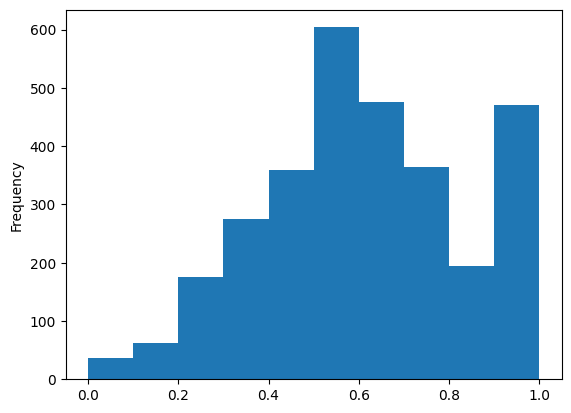

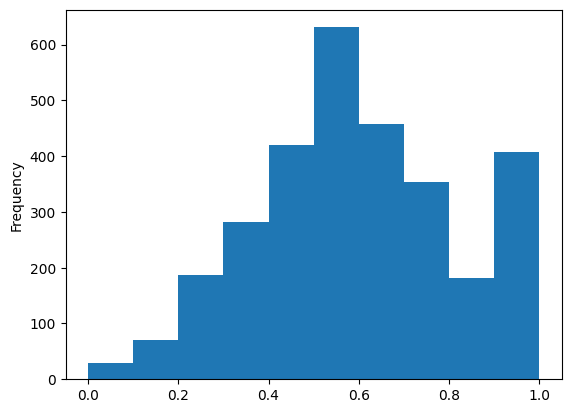

In [20]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [21]:
compute_correlations(data, METRIC)

pearsonr average, jaccard_2_L (0.5318112801094779, 4.447659979372109e-220)
pearsonr expert, jaccard_2_L (0.46610285552625874, 1.0518691948291404e-162)
pearsonr average, jaccard_2_XL (0.5145423651198499, 9.206991970781228e-204)
pearsonr expert, jaccard_2_XL (0.46144915576086326, 4.2577845409708973e-159)
kendalltau average, jaccard_2_L KendalltauResult(correlation=0.41288631543567766, pvalue=3.3294162017002086e-226)
kendalltau expert, jaccard_2_L KendalltauResult(correlation=0.3917132170034382, pvalue=1.2553358612507987e-166)
kendalltau average, jaccard_2_XL KendalltauResult(correlation=0.3964585758552472, pvalue=1.2022586501762825e-209)
kendalltau expert, jaccard_2_XL KendalltauResult(correlation=0.38140455824349273, pvalue=8.961658387316638e-159)


### Jacard Similarity Tri-grams

In [22]:
METRIC = "jaccard_3"
data[f"{METRIC}_L"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i], 3) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i], 3) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,Jaccard_sim_L,Jaccard_sim_XL,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,0.666667,0.666667,0.461538,0.461538,0.333333,0.333333
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,0.636364,0.636364,0.444444,0.481481,0.321429,0.344828
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,0.900000,0.900000,0.700000,0.700000,0.666667,0.666667
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,0.666667,0.800000,0.142857,0.400000,0.000000,0.250000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,0.863636,0.750000,0.720000,0.517241,0.576923,0.354839


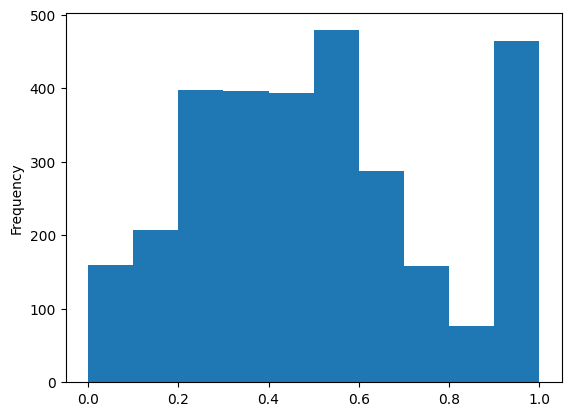

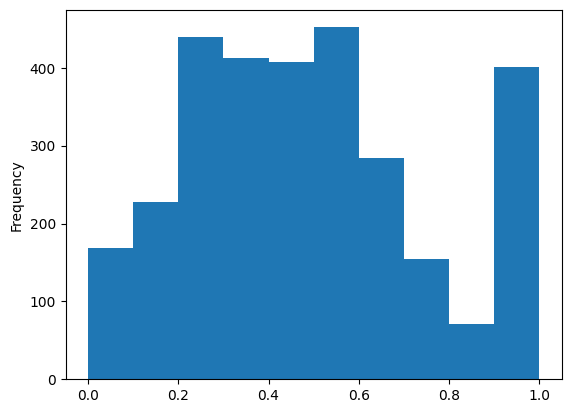

In [23]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [24]:
compute_correlations(data, METRIC)

pearsonr average, jaccard_3_L (0.5265806343692275, 4.899348489668219e-215)
pearsonr expert, jaccard_3_L (0.4701948106419811, 6.362788588633005e-166)
pearsonr average, jaccard_3_XL (0.5082533742264741, 4.742406391790739e-198)
pearsonr expert, jaccard_3_XL (0.46582190357455977, 1.7431131106178179e-162)
kendalltau average, jaccard_3_L KendalltauResult(correlation=0.39880364236213806, pvalue=3.155010401732423e-211)
kendalltau expert, jaccard_3_L KendalltauResult(correlation=0.38542027206419543, pvalue=2.0257808514495476e-161)
kendalltau average, jaccard_3_XL KendalltauResult(correlation=0.38461236753101874, pvalue=1.8637397662763048e-197)
kendalltau expert, jaccard_3_XL KendalltauResult(correlation=0.3783239589891793, pvalue=2.832369801672153e-156)


### Jaccard Similarity 4-grams

In [25]:
METRIC = "jaccard_4"
data[f"{METRIC}_L"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i], 4) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jaccard_similarity_ngrams(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i], 4) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,Jaccard_sim_L,Jaccard_sim_XL,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,40.731682,40.731564,0.666667,0.666667,0.461538,0.461538,0.333333,0.333333,0.214286,0.214286
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,80.205193,51.827534,0.636364,0.636364,0.444444,0.481481,0.321429,0.344828,0.206897,0.233333
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,64.042496,64.042526,0.900000,0.900000,0.700000,0.700000,0.666667,0.666667,0.625000,0.625000
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,258.384460,635.974060,0.666667,0.800000,0.142857,0.400000,0.000000,0.250000,0.000000,0.000000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,77.734238,49.787502,0.863636,0.750000,0.720000,0.517241,0.576923,0.354839,0.444444,0.250000


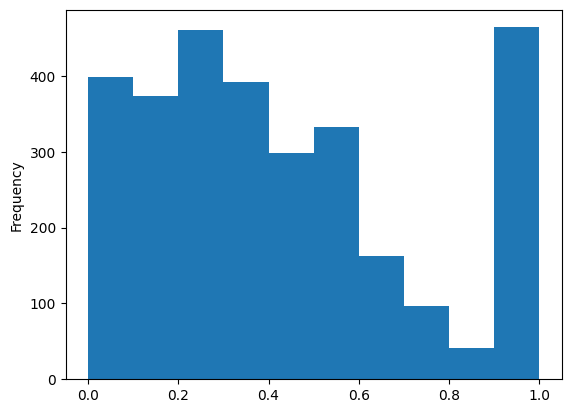

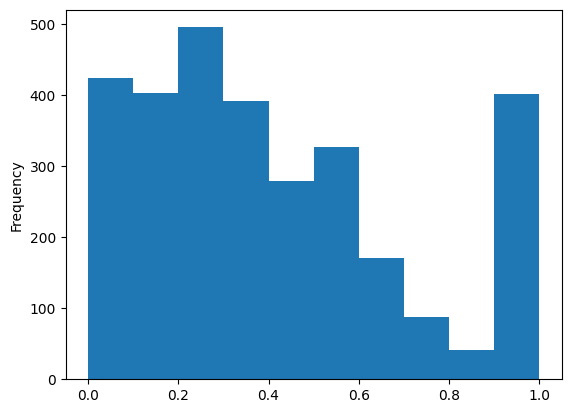

In [26]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [27]:
compute_correlations(data, METRIC)

pearsonr average, jaccard_4_L (0.5130966575336159, 1.9399360220362472e-202)
pearsonr expert, jaccard_4_L (0.4643703465915049, 2.3519040708406485e-161)
pearsonr average, jaccard_4_XL (0.4939164815148441, 1.8132155318304853e-185)
pearsonr expert, jaccard_4_XL (0.45914218927747263, 2.4931556838459263e-157)
kendalltau average, jaccard_4_L KendalltauResult(correlation=0.38285629842200003, pvalue=4.2669069853626306e-194)
kendalltau expert, jaccard_4_L KendalltauResult(correlation=0.37478071228169196, pvalue=3.658170150404034e-152)
kendalltau average, jaccard_4_XL KendalltauResult(correlation=0.36837460742527234, pvalue=1.2524098455875869e-180)
kendalltau expert, jaccard_4_XL KendalltauResult(correlation=0.36668582597296556, pvalue=2.2114796652874954e-146)


### Levenshtein Distance

compute

In [28]:
data["levenshtein_L"] = [jellyfish.levenshtein_distance(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data["levenshtein_XL"] = [jellyfish.levenshtein_distance(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,Jaccard_sim_L,Jaccard_sim_XL,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.666667,0.666667,0.461538,0.461538,0.333333,0.333333,0.214286,0.214286,12,12
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.636364,0.636364,0.444444,0.481481,0.321429,0.344828,0.206897,0.233333,10,14
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.900000,0.900000,0.700000,0.700000,0.666667,0.666667,0.625000,0.625000,4,4
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.666667,0.800000,0.142857,0.400000,0.000000,0.250000,0.000000,0.000000,5,2
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.863636,0.750000,0.720000,0.517241,0.576923,0.354839,0.444444,0.250000,4,11


normalize

In [29]:
data["levenshtein_L"] = normalize(data["levenshtein_L"])
data["levenshtein_XL"] = normalize(data["levenshtein_XL"])
display(data.head())

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,Jaccard_sim_L,Jaccard_sim_XL,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.666667,0.666667,0.461538,0.461538,0.333333,0.333333,0.214286,0.214286,0.085714,0.164384
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.636364,0.636364,0.444444,0.481481,0.321429,0.344828,0.206897,0.233333,0.071429,0.191781
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.900000,0.900000,0.700000,0.700000,0.666667,0.666667,0.625000,0.625000,0.028571,0.054795
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.666667,0.800000,0.142857,0.400000,0.000000,0.250000,0.000000,0.000000,0.035714,0.027397
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.863636,0.750000,0.720000,0.517241,0.576923,0.354839,0.444444,0.250000,0.028571,0.150685


switch

In [30]:
data["levenshtein_L"] = 1 - data["levenshtein_L"]
data["levenshtein_XL"] = 1 - data["levenshtein_XL"]

plot

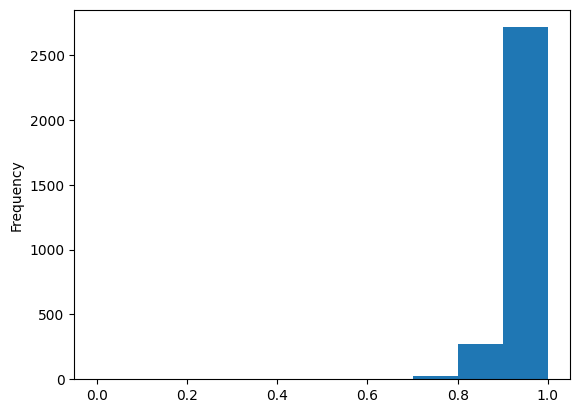

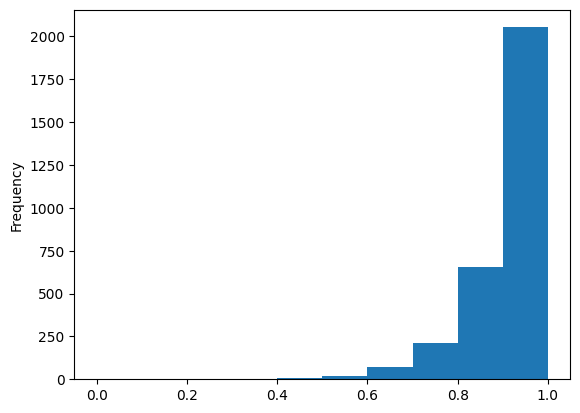

In [31]:
data["levenshtein_L"].plot(kind="hist")
plt.show()
data["levenshtein_XL"].plot(kind="hist")
plt.show()

correlation

In [32]:
compute_correlations(data, "levenshtein")

pearsonr average, levenshtein_L (0.4669532587374723, 2.2736588990752188e-163)
pearsonr expert, levenshtein_L (0.4181318672695065, 4.3904651444064057e-128)
pearsonr average, levenshtein_XL (0.4806635572870964, 2.332229625761577e-174)
pearsonr expert, levenshtein_XL (0.4545258120052786, 7.81944125478272e-154)
kendalltau average, levenshtein_L KendalltauResult(correlation=0.44700900548572936, pvalue=3.1543870218126954e-254)
kendalltau expert, levenshtein_L KendalltauResult(correlation=0.4405498475519625, pvalue=7.357128425201413e-202)
kendalltau average, levenshtein_XL KendalltauResult(correlation=0.43046706868136986, pvalue=1.423485147306396e-236)
kendalltau expert, levenshtein_XL KendalltauResult(correlation=0.43770755625906044, pvalue=7.597612973081489e-200)


### Damerau Levenshtein Distance

In [33]:
METRIC = "damerau_levenshtein"

In [34]:
data[f"{METRIC}_L"] = [jellyfish.damerau_levenshtein_distance(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jellyfish.damerau_levenshtein_distance(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL,damerau_levenshtein_L,damerau_levenshtein_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.461538,0.461538,0.333333,0.333333,0.214286,0.214286,0.914286,0.835616,11,11
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.444444,0.481481,0.321429,0.344828,0.206897,0.233333,0.928571,0.808219,10,14
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.700000,0.700000,0.666667,0.666667,0.625000,0.625000,0.971429,0.945205,4,4
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.142857,0.400000,0.000000,0.250000,0.000000,0.000000,0.964286,0.972603,5,2
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.720000,0.517241,0.576923,0.354839,0.444444,0.250000,0.971429,0.849315,4,11


In [35]:
data[f"{METRIC}_L"] = normalize(data[f"{METRIC}_L"])
data[f"{METRIC}_XL"] = normalize(data[f"{METRIC}_XL"])
display(data.head())

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,jaccard_2_L,jaccard_2_XL,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL,damerau_levenshtein_L,damerau_levenshtein_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.461538,0.461538,0.333333,0.333333,0.214286,0.214286,0.914286,0.835616,0.078571,0.150685
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.444444,0.481481,0.321429,0.344828,0.206897,0.233333,0.928571,0.808219,0.071429,0.191781
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.700000,0.700000,0.666667,0.666667,0.625000,0.625000,0.971429,0.945205,0.028571,0.054795
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.142857,0.400000,0.000000,0.250000,0.000000,0.000000,0.964286,0.972603,0.035714,0.027397
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.720000,0.517241,0.576923,0.354839,0.444444,0.250000,0.971429,0.849315,0.028571,0.150685


In [36]:
data[f"{METRIC}_L"] = 1 - data[f"{METRIC}_L"]
data[f"{METRIC}_XL"] = 1 - data[f"{METRIC}_XL"]

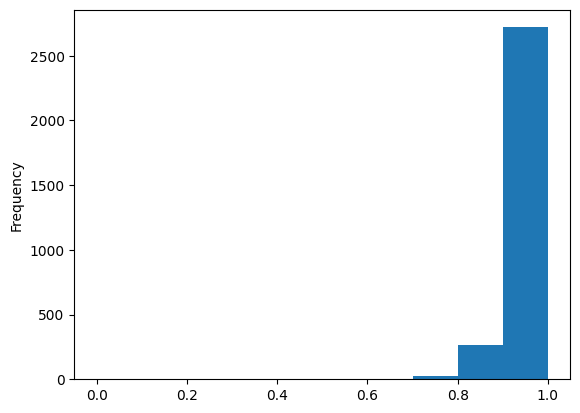

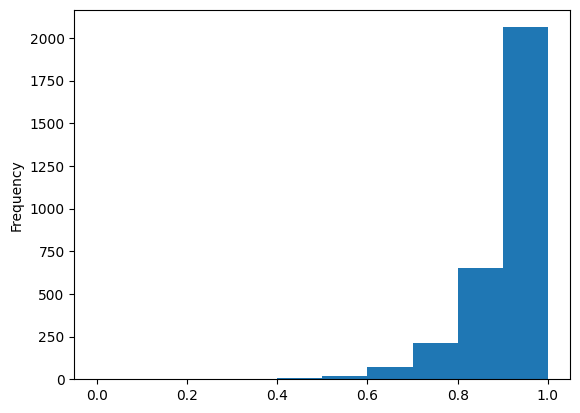

In [37]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [38]:
compute_correlations(data, METRIC)

pearsonr average, damerau_levenshtein_L (0.46579675576037494, 1.823688537820722e-162)
pearsonr expert, damerau_levenshtein_L (0.4182311535173121, 3.771170075086265e-128)
pearsonr average, damerau_levenshtein_XL (0.47909096423221753, 4.5062126724898335e-173)
pearsonr expert, damerau_levenshtein_XL (0.4546555673803775, 6.246453196658591e-154)
kendalltau average, damerau_levenshtein_L KendalltauResult(correlation=0.44723830412741195, pvalue=2.2865716525669434e-254)
kendalltau expert, damerau_levenshtein_L KendalltauResult(correlation=0.44218257881183914, pvalue=3.006925106736913e-203)
kendalltau average, damerau_levenshtein_XL KendalltauResult(correlation=0.4297770413778568, pvalue=1.0254111490524384e-235)
kendalltau expert, damerau_levenshtein_XL KendalltauResult(correlation=0.43894476501088536, pvalue=7.10912188158122e-201)


### Jaro Similarity

In [39]:
METRIC = "jaro"
data[f"{METRIC}_L"] = [jellyfish.jaro_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jellyfish.jaro_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,jaccard_3_L,jaccard_3_XL,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL,damerau_levenshtein_L,damerau_levenshtein_XL,jaro_L,jaro_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.333333,0.333333,0.214286,0.214286,0.914286,0.835616,0.921429,0.849315,0.882266,0.882266
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.321429,0.344828,0.206897,0.233333,0.928571,0.808219,0.928571,0.808219,0.862267,0.816352
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.666667,0.666667,0.625000,0.625000,0.971429,0.945205,0.971429,0.945205,0.958493,0.958493
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.000000,0.250000,0.000000,0.000000,0.964286,0.972603,0.964286,0.972603,0.858135,0.942130
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.576923,0.354839,0.444444,0.250000,0.971429,0.849315,0.971429,0.849315,0.900425,0.827273


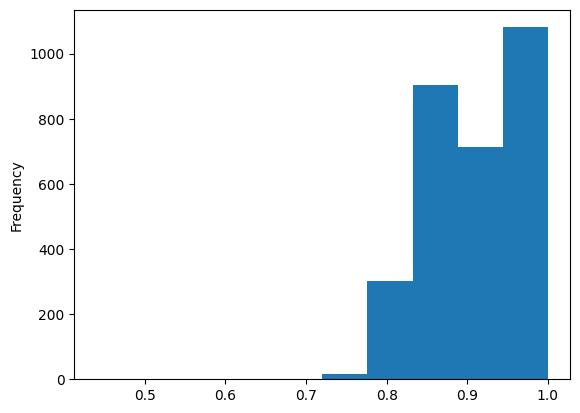

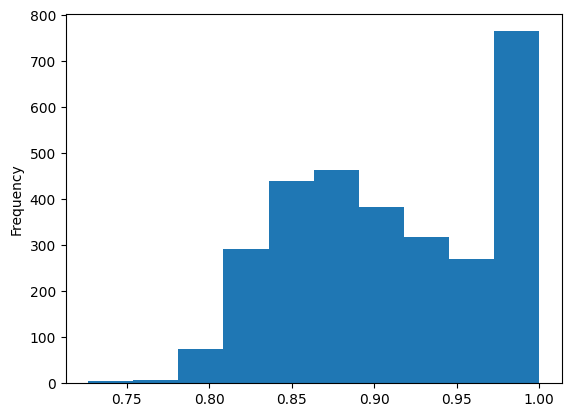

In [40]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [41]:
compute_correlations(data, METRIC)

pearsonr average, jaro_L (0.5179883737935784, 6.068957308399836e-207)
pearsonr expert, jaro_L (0.4487258686448145, 1.6229945590930074e-149)
pearsonr average, jaro_XL (0.505286966459811, 2.1325916001289525e-195)
pearsonr expert, jaro_XL (0.45489824412533664, 4.102894551402956e-154)
kendalltau average, jaro_L KendalltauResult(correlation=0.40195688087906756, pvalue=3.2988559460538644e-216)
kendalltau expert, jaro_L KendalltauResult(correlation=0.3761865759410742, pvalue=4.621939072904755e-155)
kendalltau average, jaro_XL KendalltauResult(correlation=0.3890117826372697, pvalue=1.3498826979266274e-203)
kendalltau expert, jaro_XL KendalltauResult(correlation=0.3792284314416953, pvalue=2.740564929791837e-158)


### Jaro-Winkler Similarity

In [42]:
METRIC = "jaro-winkler"
data[f"{METRIC}_L"] = [jellyfish.jaro_winkler_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [jellyfish.jaro_winkler_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,jaccard_4_L,jaccard_4_XL,levenshtein_L,levenshtein_XL,damerau_levenshtein_L,damerau_levenshtein_XL,jaro_L,jaro_XL,jaro-winkler_L,jaro-winkler_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.214286,0.214286,0.914286,0.835616,0.921429,0.849315,0.882266,0.882266,0.929359,0.929359
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.206897,0.233333,0.928571,0.808219,0.928571,0.808219,0.862267,0.816352,0.917360,0.889811
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.625000,0.625000,0.971429,0.945205,0.971429,0.945205,0.958493,0.958493,0.975096,0.975096
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.000000,0.000000,0.964286,0.972603,0.964286,0.972603,0.858135,0.942130,0.914881,0.965278
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.444444,0.250000,0.971429,0.849315,0.971429,0.849315,0.900425,0.827273,0.940255,0.896364


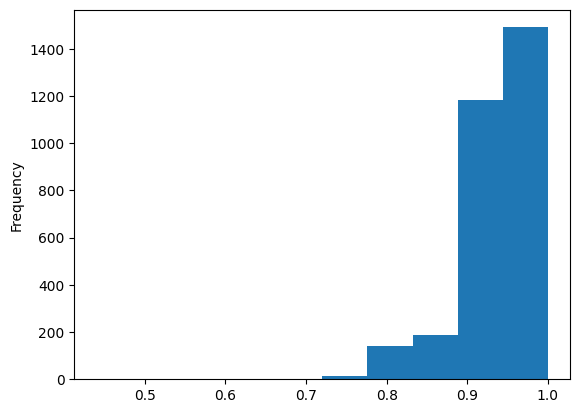

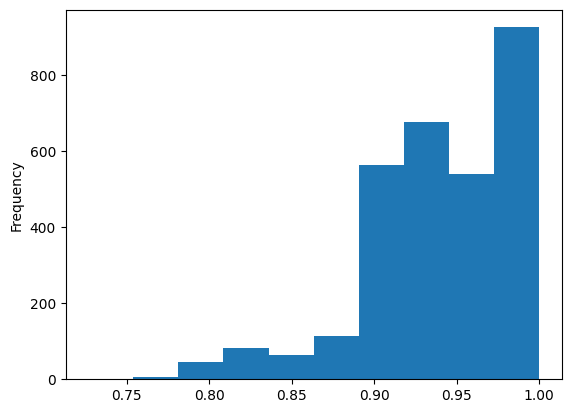

In [43]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [44]:
compute_correlations(data, METRIC)

pearsonr average, jaro-winkler_L (0.47944508482455744, 2.3163495083857815e-173)
pearsonr expert, jaro-winkler_L (0.3955375881017912, 1.2657731603518753e-113)
pearsonr average, jaro-winkler_XL (0.4701200550451651, 7.291830232158577e-166)
pearsonr expert, jaro-winkler_XL (0.4072171040569527, 5.8533718590466584e-121)
kendalltau average, jaro-winkler_L KendalltauResult(correlation=0.404892190428831, pvalue=2.3914225925426266e-219)
kendalltau expert, jaro-winkler_L KendalltauResult(correlation=0.371311505660268, pvalue=4.0231297798771486e-151)
kendalltau average, jaro-winkler_XL KendalltauResult(correlation=0.38728974441233044, pvalue=8.111610426903964e-202)
kendalltau expert, jaro-winkler_XL KendalltauResult(correlation=0.3685231546848905, pvalue=1.3628474202212885e-149)


### String similarity (Python)

In [45]:
from difflib import SequenceMatcher

def str_similarity(str1: str, str2: str) -> float:
    m = SequenceMatcher(None, str1, str2)
    return m.ratio()

In [46]:
METRIC = "str_sim"
data[f"{METRIC}_L"] = [str_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [str_similarity(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,levenshtein_L,levenshtein_XL,damerau_levenshtein_L,damerau_levenshtein_XL,jaro_L,jaro_XL,jaro-winkler_L,jaro-winkler_XL,str_sim_L,str_sim_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.914286,0.835616,0.921429,0.849315,0.882266,0.882266,0.929359,0.929359,0.931373,0.931373
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.928571,0.808219,0.928571,0.808219,0.862267,0.816352,0.917360,0.889811,0.947867,0.913242
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.971429,0.945205,0.971429,0.945205,0.958493,0.958493,0.975096,0.975096,0.964286,0.964286
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.964286,0.972603,0.964286,0.972603,0.858135,0.942130,0.914881,0.965278,0.864865,0.941176
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.971429,0.849315,0.971429,0.849315,0.900425,0.827273,0.940255,0.896364,0.982143,0.952381


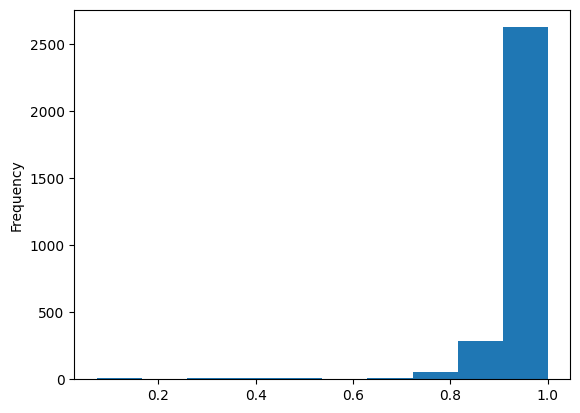

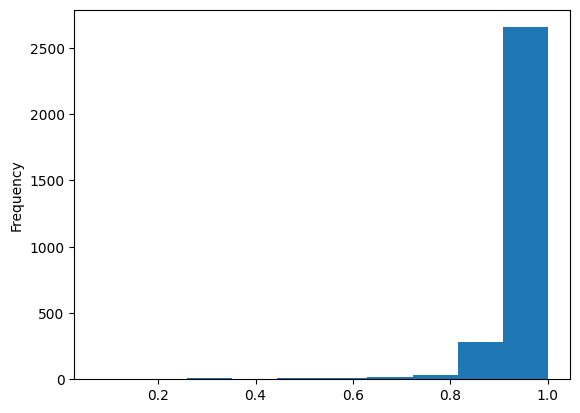

In [47]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [48]:
compute_correlations(data, METRIC)

pearsonr average, str_sim_L (0.3257191734306588, 1.4879083488866082e-75)
pearsonr expert, str_sim_L (0.2948410870498762, 1.2897835591610409e-61)
pearsonr average, str_sim_XL (0.307836006231494, 2.8077160826906095e-67)
pearsonr expert, str_sim_XL (0.28960834164001936, 2.0365805356208335e-59)
kendalltau average, str_sim_L KendalltauResult(correlation=0.42440254010829104, pvalue=1.4827745840856293e-240)
kendalltau expert, str_sim_L KendalltauResult(correlation=0.4201071095059974, pvalue=1.0861224777747107e-192)
kendalltau average, str_sim_XL KendalltauResult(correlation=0.4023851927164821, pvalue=1.871519291229424e-217)
kendalltau expert, str_sim_XL KendalltauResult(correlation=0.40996392325069186, pvalue=1.9272910941207939e-184)


### MaxSim (own function)

In [49]:
def percentage_correct(str1: str, str2:str) -> float:
    words1 = np.array(str1.split())
    words2 = np.array(str2.split())

    if len(words1) >= len(words2):
        iter_words1 = words1
        iter_words2 = words2
    else:
        iter_words1 = words2
        iter_words2 = words1

    def closest_word(word: str):
        lambda_distances = np.vectorize(lambda x: jellyfish.levenshtein_distance(word, x))
        distances = lambda_distances(iter_words2)
        return iter_words2[np.argmin(distances)]
    
    vclosest_word = np.vectorize(closest_word)

    cmp_words1 = iter_words1
    cmp_words2 = vclosest_word(iter_words1)

    is_same = cmp_words1 == cmp_words2

    return np.sum(is_same)/len(cmp_words1)

In [50]:
METRIC = "percentage_correct"
data[f"{METRIC}_L"] = [percentage_correct(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [percentage_correct(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,damerau_levenshtein_L,damerau_levenshtein_XL,jaro_L,jaro_XL,jaro-winkler_L,jaro-winkler_XL,str_sim_L,str_sim_XL,percentage_correct_L,percentage_correct_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.921429,0.849315,0.882266,0.882266,0.929359,0.929359,0.931373,0.931373,0.809524,0.809524
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.928571,0.808219,0.862267,0.816352,0.917360,0.889811,0.947867,0.913242,0.809524,0.818182
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.971429,0.945205,0.958493,0.958493,0.975096,0.975096,0.964286,0.964286,0.900000,0.900000
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.964286,0.972603,0.858135,0.942130,0.914881,0.965278,0.864865,0.941176,0.666667,0.800000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.971429,0.849315,0.900425,0.827273,0.940255,0.896364,0.982143,0.952381,0.913043,0.833333


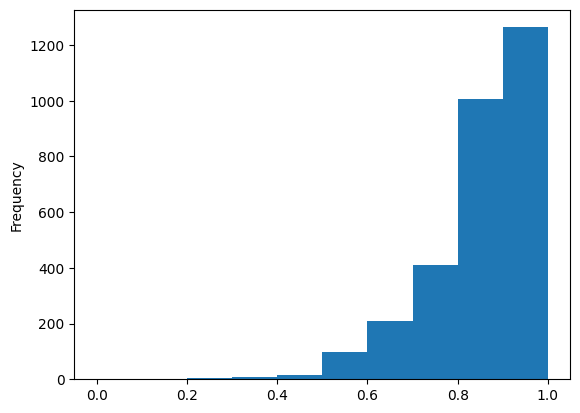

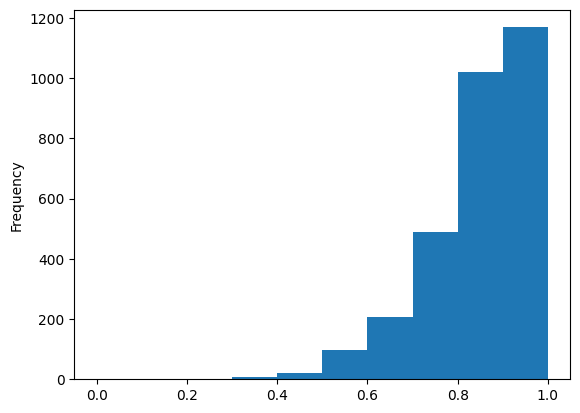

In [51]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [52]:
compute_correlations(data, METRIC)

pearsonr average, percentage_correct_L (0.4478930678191082, 6.65827114480648e-149)
pearsonr expert, percentage_correct_L (0.37665194549568903, 2.2525148234833826e-102)
pearsonr average, percentage_correct_XL (0.42891855442277094, 2.1721579153204032e-135)
pearsonr expert, percentage_correct_XL (0.3754988489831528, 1.037031686204633e-101)
kendalltau average, percentage_correct_L KendalltauResult(correlation=0.38481609578410125, pvalue=1.0534763507877917e-194)
kendalltau expert, percentage_correct_L KendalltauResult(correlation=0.35851019949514423, pvalue=1.917685148230374e-138)
kendalltau average, percentage_correct_XL KendalltauResult(correlation=0.3653098497716598, pvalue=2.0675984557556158e-176)
kendalltau expert, percentage_correct_XL KendalltauResult(correlation=0.34975972661906685, pvalue=2.0293516955434815e-132)


### Language tool

Napoles et.al. 2016 https://aclanthology.org/D16-1228/

In [53]:
tool = language_tool_python.LanguageTool(language='en-UK')

In [54]:
def lt_gbm(str1: str):
    return 1 - (len(tool.check(str1))/len(str1.split()))

In [55]:
METRIC = "LT-GBM"
data[f"{METRIC}_L"] = [lt_gbm(data["Sentence"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [lt_gbm(data["Sentence"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,jaro_L,jaro_XL,jaro-winkler_L,jaro-winkler_XL,str_sim_L,str_sim_XL,percentage_correct_L,percentage_correct_XL,LT-GBM_L,LT-GBM_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,0.882266,0.882266,0.929359,0.929359,0.931373,0.931373,0.809524,0.809524,1.000000,1.000000
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.862267,0.816352,0.917360,0.889811,0.947867,0.913242,0.809524,0.818182,0.952381,0.952381
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,0.958493,0.958493,0.975096,0.975096,0.964286,0.964286,0.900000,0.900000,1.000000,1.000000
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,0.858135,0.942130,0.914881,0.965278,0.864865,0.941176,0.666667,0.800000,1.000000,1.000000
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,0.900425,0.827273,0.940255,0.896364,0.982143,0.952381,0.913043,0.833333,1.000000,1.000000


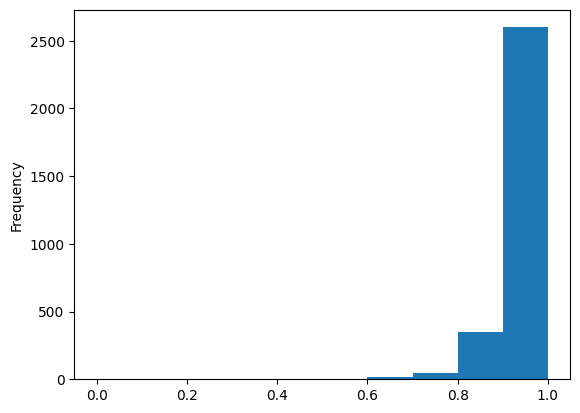

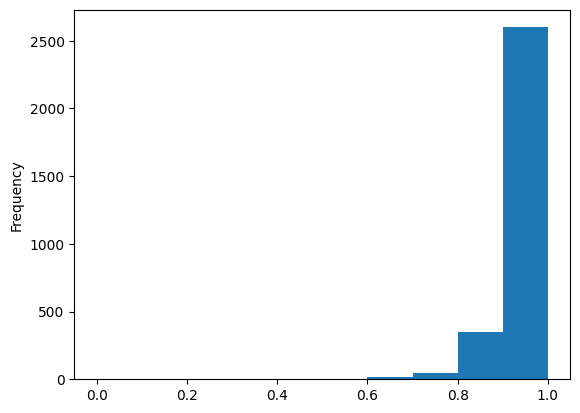

In [56]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [57]:
compute_correlations(data, METRIC)

pearsonr average, LT-GBM_L (0.2591115078468871, 1.643092026287552e-47)
pearsonr expert, LT-GBM_L (0.2017945612840342, 4.1475241328816206e-29)
pearsonr average, LT-GBM_XL (0.2591115078468871, 1.643092026287552e-47)
pearsonr expert, LT-GBM_XL (0.2017945612840342, 4.1475241328816206e-29)
kendalltau average, LT-GBM_L KendalltauResult(correlation=0.2630679148657778, pvalue=1.2240225815768624e-77)
kendalltau expert, LT-GBM_L KendalltauResult(correlation=0.22878331347209838, pvalue=1.3528551615025087e-48)
kendalltau average, LT-GBM_XL KendalltauResult(correlation=0.2630679148657778, pvalue=1.2240225815768624e-77)
kendalltau expert, LT-GBM_XL KendalltauResult(correlation=0.22878331347209838, pvalue=1.3528551615025087e-48)


### Correct

In [26]:
def is_correct(str1:str, str2:str) -> bool:
    return str1==str2

In [27]:
METRIC = "correct"
data[f"{METRIC}_L"] = [is_correct(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [is_correct(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL,correct_L,correct_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,1,1,False,False,False,False,False
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,1,1,False,False,False,False,False
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,-1,-1,False,True,True,False,False
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,1,1,False,False,False,False,False
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,1,1,False,False,False,False,False


In [28]:
np.unique(data[f"{METRIC}_L"], return_counts=True)

(array([False,  True]), array([2560,  459]))

In [29]:
np.unique(data[f"{METRIC}_XL"], return_counts=True)

(array([False,  True]), array([2623,  396]))

In [30]:
np.unique(data[f"Expert Judgement"], return_counts=True)

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([  72,  538, 1431,  978]))

In [32]:
np.unique(data[f"binary_scribendi_L"], return_counts=True)

(array([False,  True]), array([2442,  577]))

In [33]:
np.unique(data[f"binary_scribendi_XL"], return_counts=True)

(array([False,  True]), array([2511,  508]))

In [31]:
from sklearn import metrics

metrics.accuracy_score(y_true=data["binary_expert"], y_pred=data[f"{METRIC}_L"])

0.7691288506127857

In [34]:
metrics.accuracy_score(y_true=data["binary_expert"], y_pred=data[f"{METRIC}_XL"])

0.7654852600198742

### Scribendi Score

https://aclanthology.org/2021.emnlp-main.239.pdf

In [13]:
from evaluate import load
perplexity = load("perplexity", module_type="metric")


def lev_dist_ratio(src:str, pred: str) -> float:
    return 1 - (jellyfish.levenshtein_distance(src, pred)/(len(src) + len(pred)))

def scribendi_score(data_line, pred_column:str) -> int:
    src = data_line["Sentence"]
    pred = data_line[pred_column]
    ppl_source = data_line["pplxt_sentence"]
    ppl_prediction = data_line[f"pplxt_{pred_column}"]

    if pred == src:
        return 0
    
    # ppl_source = perplexity.compute(model_id='gpt2',predictions=src)["mean_perplexity"]
    # ppl_prediction =perplexity.compute(model_id='gpt2',predictions=pred)["mean_perplexity"]

    if ppl_source <= ppl_prediction:
        return -1
    else:
        tsr = fuzz.token_sort_ratio(src, pred)/100
        ldr = lev_dist_ratio(src, pred)
        if max(tsr, ldr) >= 0.8:
            return 1
        else:
            return -1

In [14]:
METRIC = "scribendi"
data[f"{METRIC}_L"] = [scribendi_score(data.iloc[i], "FixedSentence_CoeditLarge") for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [scribendi_score(data.iloc[i], "FixedSentence_CoeditXL") for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,scribendi_L,scribendi_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,1,1
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,1,1
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,-1,-1
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,1,1
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,1,1


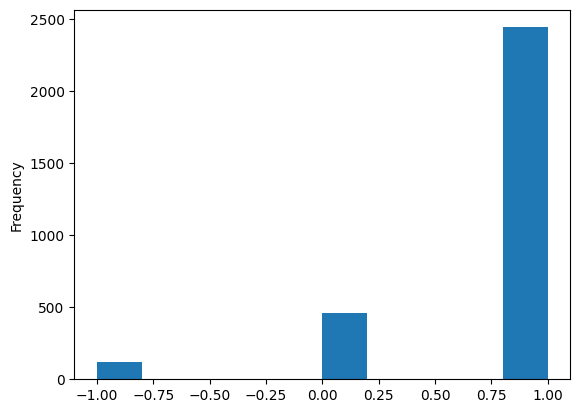

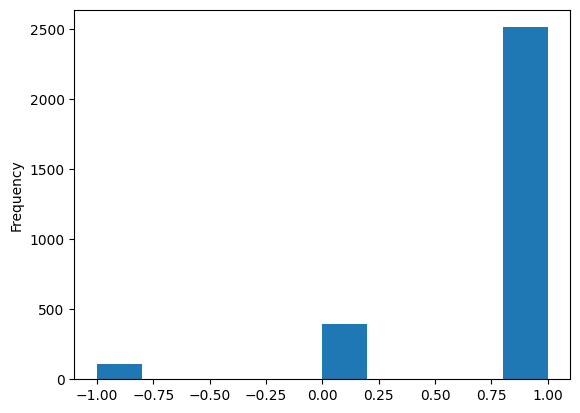

In [15]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [16]:
np.unique(data[f"{METRIC}_L"], return_counts=True)

(array([-1,  0,  1]), array([ 118,  459, 2442]))

In [17]:
np.unique(data[f"{METRIC}_XL"], return_counts=True)

(array([-1,  0,  1]), array([ 112,  396, 2511]))

In [18]:
np.unique(data[f"Expert Judgement"], return_counts=True)

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([  72,  538, 1431,  978]))

In [19]:
data["binary_expert"] = data["Expert Judgement"] == 1

In [20]:
data[f"binary_{METRIC}_L"] = data[f"{METRIC}_L"] != 1

In [21]:
from sklearn import metrics

metrics.accuracy_score(y_true=data["binary_expert"], y_pred=data[f"binary_{METRIC}_L"])

0.7697913216296787

In [22]:
data[f"binary_{METRIC}_XL"] = data[f"{METRIC}_XL"] != 1

In [23]:
metrics.accuracy_score(y_true=data["binary_expert"], y_pred=data[f"binary_{METRIC}_XL"])

0.7714474991719112

In [24]:
data

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,1,1,False,False,False
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,1,1,False,False,False
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,-1,-1,False,True,True
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,1,1,False,False,False
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,1,1,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3124,3124,3125,Sceene of violence can affect on them .,0.666667,"[2, 2, 3, 3, 3]",0.555556,test,Scenes of violence can affect them.,The scene of violence can affect them .,1779.499634,409.441437,184.862381,1,1,False,False,False
3125,3125,3125,3126,"In other words, the image in the TV comercial ...",0.333333,"[3, 1, 2, 3, 3]",0.444444,dev,"In other words, the image in the TV commercial...","In other words, the image in the TV commercial...",82.769379,25.436802,25.695061,1,1,False,False,False
3126,3126,3126,3127,Members gather money for the funeral and help ...,1.000000,"[3, 4, 4, 4, 3]",0.888889,dev,Members gather money for the funeral and help ...,Members gather money for the funeral and help ...,265.311066,265.311066,265.308929,0,0,True,True,True
3127,3127,3127,3128,Show the employer that you are willing to do a...,1.000000,"[2, 3, 4, 3, 4]",0.777778,train,Show your employer that you are willing to do ...,Show the employer that you are willing to do a...,39.979969,36.265869,30.948215,1,1,True,False,False


In [25]:
def compute_correlations_bin(df, metric_name):
    corr2 = stats.pearsonr(df["binary_expert"], df[f"binary_{metric_name}_L"])
    corr4 = stats.pearsonr(df["binary_expert"], df[f"binary_{metric_name}_XL"])
    
    kcorr2 = stats.kendalltau(df["binary_expert"], df[f"binary_{metric_name}_L"])
    kcorr4 = stats.kendalltau(df["binary_expert"], df[f"binary_{metric_name}_XL"])
    
    print(f"pearsonr expert, {metric_name}_L {corr2}")
    print(f"pearsonr expert, {metric_name}_XL {corr4}")

    print(f"kendalltau expert, {metric_name}_L {kcorr2}")
    print(f"kendalltau expert, {metric_name}_XL {kcorr4}")

compute_correlations(data, METRIC)

pearsonr average, scribendi_L (-0.3431780702192889, 3.4262725046162887e-84)
pearsonr expert, scribendi_L (-0.3118882512250432, 4.195082816805378e-69)
pearsonr average, scribendi_XL (-0.34058612870284155, 7.126048887142217e-83)
pearsonr expert, scribendi_XL (-0.32380797923838367, 1.2141471520367612e-74)
kendalltau average, scribendi_L KendalltauResult(correlation=-0.3518495630618761, pvalue=3.981019075145597e-117)
kendalltau expert, scribendi_L KendalltauResult(correlation=-0.36004339537918023, pvalue=2.5551556958407764e-100)
kendalltau average, scribendi_XL KendalltauResult(correlation=-0.34186926577342325, pvalue=1.834490713550059e-110)
kendalltau expert, scribendi_XL KendalltauResult(correlation=-0.3649070218024519, pvalue=8.686574261940771e-103)


### Needleman-Wunsch

In [81]:
def compute_nw(s1, s2):
    alignment: needle.NeedlemanWunsch[str] = needle.NeedlemanWunsch(s1, s2)
    alignment.align()
    return alignment.get_score()

In [82]:
METRIC = "needleman-wunsch"
data[f"{METRIC}_L"] = [compute_nw(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [compute_nw(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,LT-GBM_XL,correct_L,correct_XL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL,needleman-wunsch_L,needleman-wunsch_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,1.000000,False,False,1,1,False,False,False,83,83
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.952381,False,False,1,1,False,False,False,90,86
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,1.000000,False,False,-1,-1,False,True,True,50,50
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,1.000000,False,False,1,1,False,False,False,11,14
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,1.000000,False,False,1,1,False,False,False,106,99


In [83]:
data[f"{METRIC}_L"] = normalize(data[f"{METRIC}_L"])
data[f"{METRIC}_XL"] = normalize(data[f"{METRIC}_XL"])
display(data.head())

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,LT-GBM_XL,correct_L,correct_XL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL,needleman-wunsch_L,needleman-wunsch_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,1.000000,False,False,1,1,False,False,False,0.233096,0.168699
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,0.952381,False,False,1,1,False,False,False,0.245552,0.174797
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,1.000000,False,False,-1,-1,False,True,True,0.174377,0.101626
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,1.000000,False,False,1,1,False,False,False,0.104982,0.028455
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,1.000000,False,False,1,1,False,False,False,0.274021,0.201220


In [84]:
data[f"{METRIC}_L"] = 1 - data[f"{METRIC}_L"]
data[f"{METRIC}_XL"] = 1 - data[f"{METRIC}_XL"]

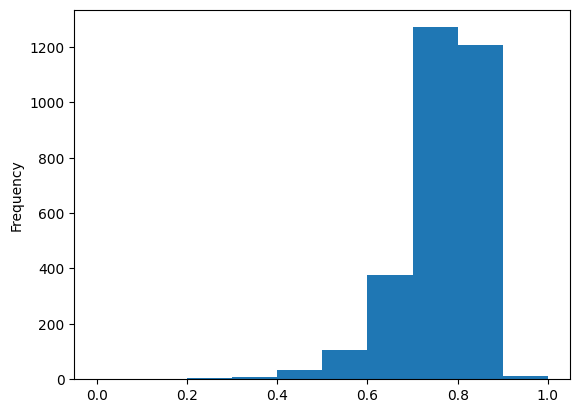

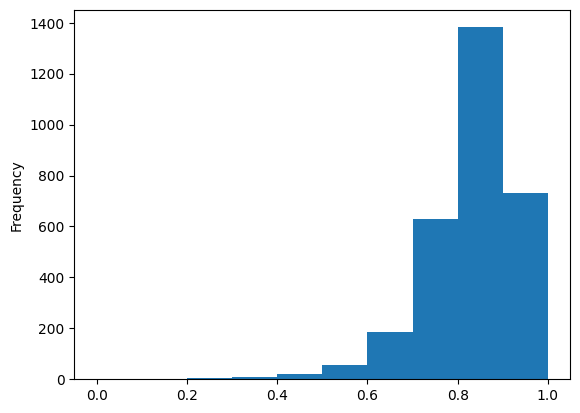

In [85]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [86]:
compute_correlations(data, METRIC)

pearsonr average, needleman-wunsch_L (0.08208728083491204, 6.299611800220699e-06)
pearsonr expert, needleman-wunsch_L (0.03410055059676559, 0.061007895002132426)
pearsonr average, needleman-wunsch_XL (0.09017657555862836, 6.946545796005707e-07)
pearsonr expert, needleman-wunsch_XL (0.03549927027746577, 0.05113685673024305)
kendalltau average, needleman-wunsch_L KendalltauResult(correlation=0.03990167842247468, pvalue=0.0017155362669103232)
kendalltau expert, needleman-wunsch_L KendalltauResult(correlation=0.022730982632286945, pvalue=0.10669089355063127)
kendalltau average, needleman-wunsch_XL KendalltauResult(correlation=0.046820311042980074, pvalue=0.00023407604166298025)
kendalltau expert, needleman-wunsch_XL KendalltauResult(correlation=0.025001829809861698, pvalue=0.07600347752288437)


### Smith-Waterman

In [87]:
def compute_sw(s1, s2):
    alignment: smith.SmithWaterman[str] = smith.SmithWaterman(s1, s2)
    alignment.align()
    return alignment.get_score()

In [88]:
METRIC = "smith-waterman"
data[f"{METRIC}_L"] = [compute_sw(data["Sentence"].iloc[i], data["FixedSentence_CoeditLarge"].iloc[i]) for i in range(data.shape[0])]
data[f"{METRIC}_XL"] = [compute_sw(data["Sentence"].iloc[i], data["FixedSentence_CoeditXL"].iloc[i]) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,correct_XL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL,needleman-wunsch_L,needleman-wunsch_XL,smith-waterman_L,smith-waterman_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,False,1,1,False,False,False,0.766904,0.831301,83,83
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,False,1,1,False,False,False,0.754448,0.825203,92,88
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,False,-1,-1,False,True,True,0.825623,0.898374,50,50
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,False,1,1,False,False,False,0.895018,0.971545,11,14
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,False,1,1,False,False,False,0.725979,0.798780,106,104


In [89]:
data[f"{METRIC}_L"] = normalize(data[f"{METRIC}_L"])
data[f"{METRIC}_XL"] = normalize(data[f"{METRIC}_XL"])
data[f"{METRIC}_L"] = 1 - data[f"{METRIC}_L"]
data[f"{METRIC}_XL"] = 1 - data[f"{METRIC}_XL"]
display(data.head())

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,...,correct_XL,scribendi_L,scribendi_XL,binary_expert,binary_scribendi_L,binary_scribendi_XL,needleman-wunsch_L,needleman-wunsch_XL,smith-waterman_L,smith-waterman_XL
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",...,False,1,1,False,False,False,0.766904,0.831301,0.843750,0.836735
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,...,False,1,1,False,False,False,0.754448,0.825203,0.826172,0.826531
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,...,False,-1,-1,False,True,True,0.825623,0.898374,0.908203,0.904082
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,...,False,1,1,False,False,False,0.895018,0.971545,0.984375,0.977551
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,...,False,1,1,False,False,False,0.725979,0.798780,0.798828,0.793878


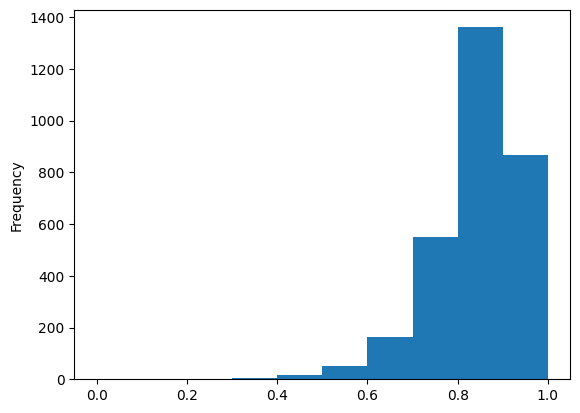

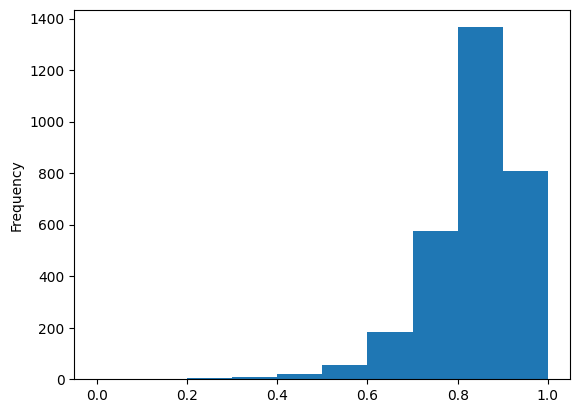

In [90]:
data[f"{METRIC}_L"].plot(kind="hist")
plt.show()
data[f"{METRIC}_XL"].plot(kind="hist")
plt.show()

In [91]:
compute_correlations(data, METRIC)

pearsonr average, smith-waterman_L (0.09030154111793352, 6.703657489330828e-07)
pearsonr expert, smith-waterman_L (0.03958715233260931, 0.029623761203105316)
pearsonr average, smith-waterman_XL (0.09414723709656977, 2.1912900337752135e-07)
pearsonr expert, smith-waterman_XL (0.03936239296973171, 0.030562261512888586)
kendalltau average, smith-waterman_L KendalltauResult(correlation=0.04592629015024645, pvalue=0.00030760735077285136)
kendalltau expert, smith-waterman_L KendalltauResult(correlation=0.028031314408416465, pvalue=0.04666269866132423)
kendalltau average, smith-waterman_XL KendalltauResult(correlation=0.05037887985088428, pvalue=7.541890821600716e-05)
kendalltau expert, smith-waterman_XL KendalltauResult(correlation=0.029156280071482982, pvalue=0.03853717688026551)


### SLOR

In [20]:
from transformers import XLNetTokenizer

tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")

In [30]:
import numpy as np
import torch

def sentence_log_prob_xlnet(sentence, model, tokenizer):
    """
    https://github.com/huggingface/transformers/issues/917 (slightly modified)
    """
    PADDING_TEXT = """In 1991, the remains of Russian Tsar Nicholas II and his family
    (except for Alexei and Maria) are discovered.
    The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
    remainder of the story. 1883 Western Siberia,
    a young Grigori Rasputin is asked by his father and a group of men to perform magic.
    Rasputin has a vision and denounces one of the men as a horse thief. Although his
    father initially slaps him for making such an accusation, Rasputin watches as the
    man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
    the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
    with people, even a bishop, begging for his blessing. <eod> """

    text = sentence

    tokenize_input = tokenizer.tokenize(PADDING_TEXT + text)
    tokenize_text = tokenizer.tokenize(text)

    sum_lp = 0.0
    for max_word_id in range((len(tokenize_input)-len(tokenize_text)), (len(tokenize_input))):

        sent = tokenize_input[:]

        input_ids = torch.tensor([tokenizer.convert_tokens_to_ids(sent)])

        perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
        perm_mask[:, :, max_word_id:] = 1.0 

        target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)
        target_mapping[0, 0, max_word_id] = 1.0

        with torch.no_grad():
            outputs = model(input_ids, perm_mask=perm_mask, target_mapping=target_mapping)
            next_token_logits = outputs[0]  # Output has shape [target_mapping.size(0), target_mapping.size(1), config.vocab_size]

        word_id = tokenizer.convert_tokens_to_ids([tokenize_input[max_word_id]])[0]
        predicted_prob = torch.softmax(torch.Tensor(next_token_logits[0][-1]),0)
        lp = np.log(predicted_prob[word_id])

        sum_lp += lp

    return float(sum_lp)

In [8]:
from transformers import XLNetTokenizer, AutoModel

tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")
model = AutoModel.from_pretrained("xlnet/xlnet-base-cased")

In [31]:
sentence_log_prob_xlnet("He is a citizen of France.", model, tokenizer)

/tmp/ipykernel_2903384/1529443971.py:43: RuntimeWarning: divide by zero encountered in log
  lp = np.log(predicted_prob[max_word_id])


-inf

In [32]:
sentence_log_prob_xlnet("He is a citizen of Tuvalu.", model, tokenizer)

/tmp/ipykernel_2903384/1529443971.py:43: RuntimeWarning: divide by zero encountered in log
  lp = np.log(predicted_prob[max_word_id])


-inf

In [21]:
import torch

def compute_slor(sentence: str, tokenizer, model):
    """
    https://aclanthology.org/K18-1031.pdf
    https://github.com/huggingface/transformers/issues/920
    https://github.com/huggingface/transformers/issues/477
    """
    #tokenize the input sentence
    tokenized_sentence = tokenizer.encode(sentence)
    tokenized_sentence_pt = tokenizer.encode(sentence, return_tensors="pt")

    #compute p_u
    p_u = 1
    for token_id in tokenized_sentence:
        p_u *= np.exp(tokenizer.sp_model.GetScore(token_id))

    #compute p_m TODO
    log_p_m = sentence_log_prob_xlnet(sentence, model, tokenizer)

    #compute slor score
    sentence_len = len(tokenized_sentence)
  

    slor_score = (1/sentence_len) * (log_p_m - np.log(p_u))


    return slor_score


In [22]:
from transformers import XLNetTokenizer, AutoModel

tokenizer = XLNetTokenizer.from_pretrained("xlnet/xlnet-base-cased")
model = AutoModel.from_pretrained("xlnet/xlnet-base-cased")


In [23]:
compute_slor("I have a car.", tokenizer, model)

AttributeError: 'XLNetModel' object has no attribute 'tokenize'

In [55]:
compute_slor("I has a car.", tokenizer, model)

2.02597971757253

In [57]:
compute_slor("He is a citizen of France.", tokenizer, model)

1.526444435119629

In [58]:
compute_slor("He is a citizen of Tuvalu.", tokenizer, model)

2.0459847083458533

count probabilites for GPT2 tokenizer

In [1]:
%pip install gdown


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Download openwebtext dataset from gdrive

https://skylion007.github.io/OpenWebTextCorpus/

In [5]:
import gdown

url = "https://drive.google.com/file/d/1EA5V0oetDCOke7afsktL_JDQ-ETtNOvx/view?usp=sharing"
output = "/home/mlynatom/data/openwebtext.tar.xz"
gdown.download(url, output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1EA5V0oetDCOke7afsktL_JDQ-ETtNOvx
From (redirected): https://drive.google.com/uc?id=1EA5V0oetDCOke7afsktL_JDQ-ETtNOvx&confirm=t&uuid=0f3a0974-1767-4313-98c4-ce9a801cc72a
To: /home/mlynatom/data/openwebtext.tar.xz
100%|██████████| 12.9G/12.9G [00:55<00:00, 233MB/s] 


'/home/mlynatom/data/openwebtext.tar.xz'

look through the dataset

In [6]:
!tar -xvf /home/mlynatom/data/openwebtext.tar.xz

openwebtext/urlsf_subset00-1000_data.xz
openwebtext/urlsf_subset00-100_data.xz
openwebtext/urlsf_subset00-101_data.xz
openwebtext/urlsf_subset00-102_data.xz
openwebtext/urlsf_subset00-103_data.xz
openwebtext/urlsf_subset00-104_data.xz
openwebtext/urlsf_subset00-105_data.xz
openwebtext/urlsf_subset00-106_data.xz
openwebtext/urlsf_subset00-107_data.xz
openwebtext/urlsf_subset00-108_data.xz
openwebtext/urlsf_subset00-109_data.xz
openwebtext/urlsf_subset00-10_data.xz
openwebtext/urlsf_subset00-110_data.xz
openwebtext/urlsf_subset00-111_data.xz
openwebtext/urlsf_subset00-112_data.xz
openwebtext/urlsf_subset00-113_data.xz
openwebtext/urlsf_subset00-114_data.xz
openwebtext/urlsf_subset00-115_data.xz
openwebtext/urlsf_subset00-116_data.xz
openwebtext/urlsf_subset00-117_data.xz
openwebtext/urlsf_subset00-118_data.xz
openwebtext/urlsf_subset00-119_data.xz
openwebtext/urlsf_subset00-11_data.xz
openwebtext/urlsf_subset00-120_data.xz
openwebtext/urlsf_subset00-121_data.xz
openwebtext/urlsf_subset00

token counts see count_tokens.py

In [13]:
import pickle

with open("data/gpt2_counts.pickle", "rb") as f:
    token_counts = pickle.load(f)

token_counts

{'Port': 56084,
 '-': 73151963,
 'au': 599659,
 'Prince': 23160,
 ',': 331931606,
 'ĠHaiti': 47902,
 'Ġ(': 30198124,
 'CNN': 92689,
 ')': 19483022,
 'Ġ--': 2264178,
 'ĠEarthquake': 7201,
 'Ġvictims': 480853,
 'Ġwr': 56670,
 'ithing': 9865,
 'Ġin': 113965578,
 'Ġpain': 476567,
 'Ġand': 155292097,
 'Ġgrasping': 13384,
 'Ġat': 28550466,
 'Ġlife': 3170305,
 'Ġwatched': 264118,
 'Ġdoctors': 283736,
 'Ġnurses': 55664,
 'Ġwalk': 524274,
 'Ġaway': 2267838,
 'Ġfrom': 27458465,
 'Ġa': 141453198,
 'Ġfield': 1036453,
 'Ġhospital': 507947,
 'ĠFriday': 1006472,
 'Ġnight': 1646016,
 'Ġafter': 7766390,
 'ĠBelgian': 59779,
 'Ġmedical': 811279,
 'Ġteam': 3708444,
 'Ġevacuated': 43629,
 'Ġthe': 329635524,
 'Ġarea': 1526402,
 'Ġsaying': 1514986,
 'Ġit': 45463809,
 'Ġwas': 40129601,
 'Ġconcerned': 454013,
 'Ġabout': 15206539,
 'Ġsecurity': 1474649,
 '.': 317457765,
 'Ċ': 315983896,
 'The': 19702725,
 'Ġdecision': 1360047,
 'Ġleft': 2568091,
 'ĠCNN': 295025,
 'ĠChief': 290977,
 'ĠMedical': 186967,
 'ĠCorres

In [14]:
num_all_occurences = sum(token_counts.values())
num_all_occurences

9032003326

In [15]:
token_frequencies = {k: v / num_all_occurences for k, v in token_counts.items()}
token_frequencies

{'Port': 6.209475127024549e-06,
 '-': 0.008099195755322731,
 'au': 6.63926903429929e-05,
 'Prince': 2.5642151761979985e-06,
 ',': 0.03675060714874675,
 'ĠHaiti': 5.303585292324548e-06,
 'Ġ(': 0.0033434580247629106,
 'CNN': 1.0262285857798632e-05,
 ')': 0.0021571097016666444,
 'Ġ--': 0.0002506839200869444,
 'ĠEarthquake': 7.972760571589718e-07,
 'Ġvictims': 5.323879793265701e-05,
 'Ġwr': 6.27435552828759e-06,
 'ithing': 1.092227232866721e-06,
 'Ġin': 0.012617973431423866,
 'Ġpain': 5.2764263120688755e-05,
 'Ġand': 0.01719353850911104,
 'Ġgrasping': 1.4818417926698624e-06,
 'Ġat': 0.003161033601240284,
 'Ġlife': 0.00035100795311642473,
 'Ġwatched': 2.9242460445037264e-05,
 'Ġdoctors': 3.141451456104125e-05,
 'Ġnurses': 6.162973815539093e-06,
 'Ġwalk': 5.804625851839506e-05,
 'Ġaway': 0.00025108914580131766,
 'Ġfrom': 0.0030401300806606898,
 'Ġa': 0.015661331478123507,
 'Ġfield': 0.00011475338998341728,
 'Ġhospital': 5.623857539310211e-05,
 'ĠFriday': 0.00011143397136521383,
 'Ġnight': 0.

In [16]:
sum(token_frequencies.values())

1.0000000000000016

In [24]:
def sentence_log_prob_gpt2(sentence, model, tokenizer, use_gpu = False):
    """
    https://github.com/sgondala/GoogleConceptualCaptioning/blob/master/misc/slor_scoring.py
    """
    tokenize_input = tokenizer.tokenize(sentence)
    # 50256 is the token_id for <|endoftext|>
    tensor_input = torch.tensor([[tokenizer.bos_token_id] + tokenizer.convert_tokens_to_ids(tokenize_input) + [tokenizer.eos_token_id]])

    if use_gpu:
        model = model.to("cuda")
        tensor_input = tensor_input.to("cuda")
    else:
        model = model.to("cpu")

    with torch.no_grad():
        outputs = model(tensor_input, labels=tensor_input)
        _, logits = outputs[:2]
    lp = 0.0
    for i in range(len(tokenize_input)):
        masked_index = i
        predicted_score = logits[0, masked_index]
        assert len(predicted_score.shape) == 1, predicted_score.shape
        # print("Predicted score ", predicted_score)
        # print("Predicted score shape", predicted_score.shape)
        predicted_prob = torch.nn.functional.softmax(predicted_score, dim=0)
        # print("Predicted prob ", predicted_prob)
        # print("predicted prob shape", predicted_prob.shape)
        lp += np.log(predicted_prob[tokenizer.convert_tokens_to_ids([tokenize_input[i]])[0]].cpu())
    return float(lp)

In [75]:
import torch

def compute_slor(sentence: str, tokenizer, model, token_frequencies, use_gpu:bool = False):
    """
    https://aclanthology.org/K18-1031.pdf
    https://github.com/huggingface/transformers/issues/920
    https://github.com/huggingface/transformers/issues/477
    https://gist.github.com/yuchenlin/eb63e2d0513f70cfc9bb85fa5a78953b
    https://discuss.huggingface.co/t/generation-probabilities-how-to-compute-probabilities-of-output-scores-for-gpt2/3175
    """
    #tokenize the input sentence
    tokenized_sentence = tokenizer.encode(sentence)
    tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence)

    #compute p_u
    p_u = 1
    for token_id in tokens:
        p_u *= token_frequencies.get(token_id, 0)

    #compute p_m
    log_p_m = sentence_log_prob_gpt2(sentence, model, tokenizer, use_gpu = use_gpu)

    #compute slor score
    sentence_len = len(tokenized_sentence)
  
    slor_score = (1/sentence_len) * (log_p_m - np.log(p_u))

    return slor_score

In [19]:
from transformers import AutoTokenizer, GPT2LMHeadModel

tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [64]:
compute_slor("I have a car i asfdna sdfkjln.", tokenizer, model, token_frequencies, use_gpu=True)

0.9172739058951658

In [25]:
compute_slor("I have a car.", tokenizer, model, token_frequencies)

2.0358125871032238

In [63]:
compute_slor("I has an cars.", tokenizer, model, token_frequencies)

-0.26831938318348997

In [62]:
compute_slor("We shall live in peace!", tokenizer, model, token_frequencies, use_gpu=True)

0.9394516371124126

In [61]:
compute_slor("We is traveling abbroadd.", tokenizer, model, token_frequencies, use_gpu=True)

-0.28433354783367376

In [77]:
display(compute_slor("He is a citizen of France.", tokenizer, model, token_frequencies, use_gpu=True))
display(compute_slor("He is a citizen of Tuvalu.", tokenizer, model, token_frequencies, use_gpu=True))
display(compute_slor("Long lives the kings!", tokenizer, model, token_frequencies, use_gpu=True))


2.9075051903708675

3.78527151016062

2.354295477000217

In [65]:
METRIC = "BPSLOR"
data[f"{METRIC}"] = [compute_slor(data["Sentence"].iloc[i], tokenizer, model, token_frequencies, use_gpu=True) for i in range(data.shape[0])]
data.head()

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,BPSLOR,norm_BPSLOR,Ex-judg-bin
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,0.461639,0.342760,False
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,0.726639,0.446122,False
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,0.518845,0.426635,False
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,-0.280457,0.012193,False
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,0.506995,0.391163,False


In [66]:
data[f"norm_{METRIC}"] = normalize(data[f"{METRIC}"])
display(data.head())

,Unnamed: 0.1,Unnamed: 0,Id,Sentence,Expert Judgement,Crowd Flower Judgements,Average,Dataset,FixedSentence_CoeditXL,FixedSentence_CoeditLarge,pplxt_sentence,pplxt_FixedSentence_CoeditLarge,pplxt_FixedSentence_CoeditXL,BPSLOR,norm_BPSLOR,Ex-judg-bin
0,0,0,1,If the teacher once entered in to the class sh...,0.666667,"[3, 3, 3, 4, 2]",0.666667,train,"If the teacher once entered the class, she sho...","If the teacher once entered the class, she sho...",135.415344,40.731682,40.731564,0.461639,0.292242,False
1,1,1,2,So I think we can not live if old people could...,0.333333,"[2, 2, 1, 2, 3]",0.333333,test,So I think we could not live if old people cou...,So I think we cannot live if old people could ...,153.998947,80.205193,51.827534,0.726639,0.383575,False
2,2,2,3,New and new technology has been introduced to ...,0.666667,"[3, 4, 3, 3, 2]",0.666667,dev,New and new technology has been introduced to ...,New and new technology has been introduced to ...,47.270332,64.042496,64.042526,0.518845,0.311958,False
3,3,3,4,For not use car.,0.000000,"[3, 4, 3, 4, 3]",0.666667,test,For not use a car.,For not to use a car.,2350.602295,258.384460,635.974060,-0.280457,0.036475,False
4,4,4,5,Here was no promise of morning except that we ...,0.666667,"[2, 4, 3, 2, 3]",0.611111,test,"Here there was no promise of morning, except t...",Here was no promise of morning except that as ...,156.606705,77.734238,49.787502,0.506995,0.307874,False


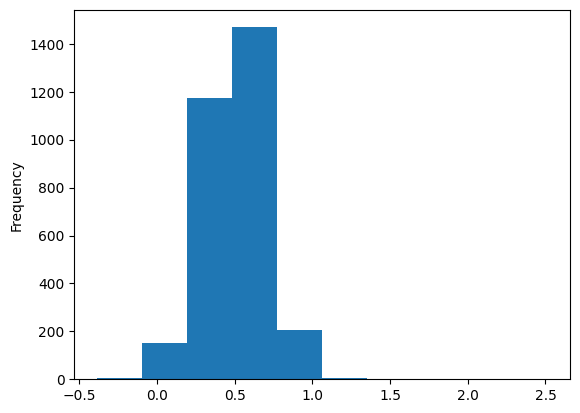

In [67]:
data[f"{METRIC}"].plot(kind="hist")
plt.show()

In [68]:
def compute_correlations_slor(df, metric_name):
    p_corr1 = stats.pearsonr(df["Average"], df[f"{metric_name}"])
    p_corr2 = stats.pearsonr(df["Expert Judgement"], df[f"{metric_name}"])

    k_corr1 = stats.kendalltau(df["Average"], df[f"{metric_name}"])
    k_corr2 = stats.kendalltau(df["Expert Judgement"], df[f"{metric_name}"])

    print(f"pearsonr average, {metric_name} {p_corr1}")
    print(f"pearsonr expert, {metric_name} {p_corr2}")
    print(f"kendalltau average, {metric_name} {k_corr1}")
    print(f"kendalltau expert, {metric_name} {k_corr2}")

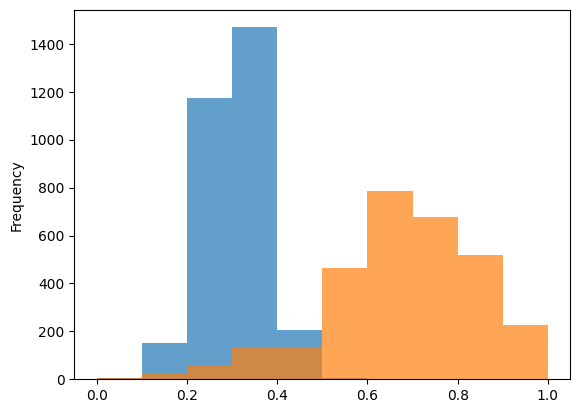

In [69]:
data[f"norm_{METRIC}"].plot(kind="hist", alpha=0.7)
data[f"Average"].plot(kind="hist", alpha=0.7)
plt.show()

In [70]:
compute_correlations_slor(data, METRIC)

pearsonr average, BPSLOR (0.41307184375831185, 9.517940331496774e-125)
pearsonr expert, BPSLOR (0.4055906935667391, 6.405293102375331e-120)
kendalltau average, BPSLOR KendalltauResult(correlation=0.32203003927893653, pvalue=2.8825871679740155e-142)
kendalltau expert, BPSLOR KendalltauResult(correlation=0.33798886929543254, pvalue=4.891416416127027e-128)


In [71]:
data["Expert Judgement"]

0       0.666667
1       0.333333
2       0.666667
3       0.000000
4       0.666667
          ...   
3124    0.666667
3125    0.333333
3126    1.000000
3127    1.000000
3128    0.666667
Name: Expert Judgement, Length: 3019, dtype: float64

In [72]:
data["Ex-judg-bin"] = data["Expert Judgement"] == 1
np.unique(data["Ex-judg-bin"].to_numpy(), return_counts=True)

(array([False,  True]), array([2041,  978]))

In [73]:
from sklearn.metrics import accuracy_score
import scipy.optimize as opt

def min_fun(threshold):
    slor_bin = data["BPSLOR"] > threshold
    acc = accuracy_score(data["Ex-judg-bin"], slor_bin)
    return -acc


res = opt.minimize_scalar(min_fun, options={"disp": True})
print(res)


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 1.48e-08 )
     fun: -0.7157999337528983
 message: '\nOptimization terminated successfully;\nThe returned value satisfies the termination criteria\n(using xtol = 1.48e-08 )'
    nfev: 35
     nit: 31
 success: True
       x: 0.6796642230280256
